#Assessing ConvNeXt V1 and V2 for Protein Classification on the SHREC 2020 Cryo-Electron Tomography Dataset

This notebook presents a comprehensive evaluation of the classification performance of pretrained **ConvNeXt V1** and **ConvNeXt V2** models on the **SHREC 2020 Cryo-Electron Tomography (Cryo-ET)** dataset—a challenging benchmark composed of simulated 3D tomograms annotated with 12 distinct macromolecular classes. Cryo-ET enables volumetric imaging of macromolecular complexes in near-native cellular environments but suffers from low signal-to-noise ratios and anisotropic resolution, necessitating the development of robust and scalable computational models for particle-level interpretation.

To address this, I implement an end-to-end multi-class classification pipeline using ConvNeXt V1 and V2 architectures pretrained on ImageNet. Each protein particle is localized using provided coordinates and represented through a **tri-view approach**: three orthogonal slices (**XY, XZ, YZ**) extracted from a \(48^3\) voxel subtomogram centered on the particle. These slices are transformed using ImageNet-compatible preprocessing, normalized, and saved for efficient reuse during training and evaluation.

The pipeline includes:

- **Data preparation**: extraction of 2D views, normalization, and conversion to `.pt` files  
- **Model adaptation**: replacing the original classification heads to support 12 output classes  
- **Training strategy**: 80/20 split on tomograms 0–8 with weighted cross-entropy loss to mitigate class imbalance, mixed precision training for speed, and a gradual unfreezing schedule (unfreezing stage 3 after epoch 5)  
- **Model selection**: early stopping and validation-based checkpointing  
- **Inference**: ensemble decision from summed class probabilities across the three views  

The test set (**tomogram 9**) is held out in accordance with SHREC 2020 protocol to ensure comparability with previously published methods. Final classification performance is measured using standard metrics: **accuracy, precision, recall, and F1-score**, with additional per-class analysis and confusion matrices provided.

This notebook serves both as a **proof of concept** and a **reproducible framework** for evaluating ConvNeXt models in the domain of cryo-ET. It highlights the potential for **transfer learning** from natural images to structural biology and offers an adaptable template for future research in macromolecular classification tasks.


## Installing Dependencies and Importing Libraries

In [1]:
!pip install mrcfile

import os
import csv
import time
import random
import shutil
from collections import Counter

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.cuda.amp import autocast, GradScaler

from PIL import Image
from torchvision import transforms

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
)

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from google.colab import files, drive, auth
from googleapiclient.discovery import build

import mrcfile


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 1.1 MB/s eta 0:00:00


## Accessing the data folder in Google Drive

In [2]:
# Mounting Google Drive to import the dataset

from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Adding the data folder as a shortcut in 'My Drive' Folder to be accessable otherwise you can download the data and upload it to your own Google Drive account

auth.authenticate_user()

drive_service = build('drive', 'v3')

# ID of the shared folder (Extracted from your link)
shared_folder_id = "1ROgxmjFOAZoFKB19cl94RgeFqtbcCfjz"

# ID of "My Drive" (root folder)
my_drive_id = "root"

# Create a shortcut
shortcut_metadata = {
    'name': 'SHREC_2020_CryoET_Dataset',
    'mimeType': 'application/vnd.google-apps.shortcut',
    'parents': [my_drive_id],
    'shortcutDetails': {'targetId': shared_folder_id}
}

shortcut = drive_service.files().create(body=shortcut_metadata).execute()

print("Shortcut created successfully!")

## Defining some helper functions

In [ ]:
# -------- Paths --------
dataset_path = "/content/drive/MyDrive/SHREC2020/shrec2020_full_dataset"
tomogram_dirs = [os.path.join(dataset_path, f'model_{i}') for i in range(9)]
save_root = '/content/drive/MyDrive/SHREC2020/slice_dataset'
csv_output_path = '/content/drive/MyDrive/SHREC2020/slice_triplets.csv'
os.makedirs(save_root, exist_ok=True)

# Path to the test tomogram and particle locations file:
model9_dir = os.path.join(dataset_path, f'model_9')
mrc_path = os.path.join(model9_dir, 'grandmodel.mrc')
locations_file = os.path.join(model9_dir, 'particle_locations.txt')

# === Class Mappings ===
pdb_to_idx = {
    '3cf3': 0, '1s3x': 1, '1u6g': 2, '4cr2': 3, '1qvr': 4, '3h84': 5,
    '2cg9': 6, '3qm1': 7, '3gl1': 8, '3d2f': 9, '4d8q': 10, '1bxn': 11
}
idx_to_pdb = {v: k for k, v in pdb_to_idx.items()}


# Load particle locations
with open(locations_file, 'r') as f:
    particles = [line.strip().split() for line in f.readlines()]


# Load tomogram volume (for inference)
with mrcfile.open(mrc_path, permissive=True) as mrc:
    volume = mrc.data.copy()

# -------- Parameters --------
patch_size = 48
half = patch_size // 2

# -------- CSV Setup --------
csv_rows = []
header = ["xy", "xz", "yz", "class"]
counter = 0


# === Image Transform for Inference ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# -------- Normalize slice before saving --------
def normalize_to_uint8(arr):
    arr = arr - arr.min()
    arr = arr / (arr.max() + 1e-8)  # avoid divide-by-zero
    return (arr * 255).astype(np.uint8)

/usr/local/lib/python3.11/dist-packages/mrcfile/mrcinterpreter.py:206: RuntimeWarning: Map ID string not found - not an MRC file, or file is corrupt
  warnings.warn(msg, RuntimeWarning)


In [ ]:
# Global Random seeds for ensuring reproducibility

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

## Training and Validation Dataset preparation (**Run for once**)

### Slicing the data (3d views: xy, xz, yz)

In [ ]:
for tomo_dir in tqdm(tomogram_dirs):
    with open(os.path.join(tomo_dir, 'particle_locations.txt'), 'r') as f:
        locations = [line.strip().split() for line in f.readlines()]

    with mrcfile.open(os.path.join(tomo_dir, 'grandmodel.mrc'), permissive=True) as mrc:
        volume = mrc.data.copy()

    shape_z, shape_y, shape_x = volume.shape

    for entry in locations:
        pdb_id, x, y, z = entry[0], int(float(entry[1])), int(float(entry[2])), int(float(entry[3]))
        cls_idx = pdb_to_idx[pdb_id]
        class_dir = os.path.join(save_root, f'class_{cls_idx}')
        os.makedirs(class_dir, exist_ok=True)

        if (x - half < 0 or y - half < 0 or z - half < 0 or
            x + half >= shape_x or y + half >= shape_y or z + half >= shape_z):
            continue

        patch = volume[z - half:z + half, y - half:y + half, x - half:x + half]

        xy = Image.fromarray(normalize_to_uint8(patch[half, :, :]))
        xz = Image.fromarray(normalize_to_uint8(patch[:, half, :]))
        yz = Image.fromarray(normalize_to_uint8(patch[:, :, half]))

        slice_base = f'{pdb_id}_{counter:05d}'
        xy_path = os.path.join(f'class_{cls_idx}', f'{slice_base}_xy.png')
        xz_path = os.path.join(f'class_{cls_idx}', f'{slice_base}_xz.png')
        yz_path = os.path.join(f'class_{cls_idx}', f'{slice_base}_yz.png')

        xy.save(os.path.join(save_root, xy_path))
        xz.save(os.path.join(save_root, xz_path))
        yz.save(os.path.join(save_root, yz_path))

        csv_rows.append([xy_path, xz_path, yz_path, cls_idx])
        counter += 1

# -------- SAVE CSV --------
with open(csv_output_path, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    writer.writerows(csv_rows)

print(f"\n All slices and CSV saved to: {save_root}")
print(f" CSV file created: {csv_output_path}")



  0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/mrcfile/mrcinterpreter.py:206: RuntimeWarning: Map ID string not found - not an MRC file, or file is corrupt
  warnings.warn(msg, RuntimeWarning)
100%|██████████| 9/9 [15:01<00:00, 100.14s/it]


 All slices and CSV saved to: /content/drive/MyDrive/SHREC2020/slice_dataset
 CSV file created: /content/drive/MyDrive/SHREC2020/slice_triplets.csv


In [ ]:
df = pd.DataFrame(csv_rows, columns=["xy", "xz", "yz", "class"])
df.to_csv('/content/drive/MyDrive/SHREC2020/slice_triplets.csv', index=False)


In [ ]:
df.head()

,xy,xz,yz,class
0,class_5/3h84_00000_xy.png,class_5/3h84_00000_xz.png,class_5/3h84_00000_yz.png,5
1,class_8/3gl1_00001_xy.png,class_8/3gl1_00001_xz.png,class_8/3gl1_00001_yz.png,8
2,class_0/3cf3_00002_xy.png,class_0/3cf3_00002_xz.png,class_0/3cf3_00002_yz.png,0
3,class_7/3qm1_00003_xy.png,class_7/3qm1_00003_xz.png,class_7/3qm1_00003_yz.png,7
4,class_3/4cr2_00004_xy.png,class_3/4cr2_00004_xz.png,class_3/4cr2_00004_yz.png,3


In [ ]:
zip_filename = 'slice_dataset.zip'

shutil.make_archive(base_name=save_root, format='zip', root_dir=save_root)



In [ ]:
files.download('/content/drive/MyDrive/SHREC2020/slice_dataset.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('/content/slice_triplets.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Creating Triplets of the extracted Slices (3 views)

In [ ]:
# -------- Paths --------
save_dir = '/content/processed_triplets'
os.makedirs(save_dir, exist_ok=True)

root_dir = "/content/drive/MyDrive/SHREC2020/slice_dataset"  # Slices folder
csv_file = "/content/slice_triplets.csv"

# -------- Process if not already done --------
if len(os.listdir(save_dir)) == 0:
    df = pd.read_csv(csv_file)
    skipped = 0

    for i, row in tqdm(df.iterrows(), total=len(df)):
        try:
            xy = transform(Image.open(os.path.join(root_dir, row['xy'])).convert('RGB'))
            xz = transform(Image.open(os.path.join(root_dir, row['xz'])).convert('RGB'))
            yz = transform(Image.open(os.path.join(root_dir, row['yz'])).convert('RGB'))

            triplet = torch.stack([xy, xz, yz])  # [3, 3, 224, 224]
            label = int(row['class'])

            sample_path = os.path.join(save_dir, f'sample_{i:05d}.pt')
            torch.save((triplet, label), sample_path)

        except Exception as e:
            print(f"Skipping sample {i} due to error: {e}")
            skipped += 1
            continue

    print(f"\n Done. Saved {len(df) - skipped} samples, Skipped: {skipped}")

    # -------- Create ZIP --------
    shutil.make_archive(save_dir, 'zip', save_dir)
    files.download(f"{save_dir}.zip")
else:
    print("Directory is not empty. Skipping preprocessing. Delete files if you want to re-run.")


In [ ]:
!cp /content/processed_triplets.zip /content/drive/MyDrive/SHREC2020/


## Training and Validation Setup

In [ ]:
# Running it when the google colab session ending to copy the data from google drive to the local disk of the google colab session
!cp -r /content/drive/MyDrive/SHREC2020/processed_triplets.zip /content/


In [ ]:
!unzip -q "/content/processed_triplets.zip" -d "/content/processed_triplets"

In [ ]:
data_folder = '/content/processed_triplets'
num_files = len([f for f in os.listdir(data_folder) if os.path.isfile(os.path.join(data_folder, f))])
print(f'The number of samples in the dataset is: {num_files}')

The number of samples in the dataset is: 19411


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

device

'cuda'

### Creating Custom Dataset Class

In [ ]:
class TripletTensorDataset(Dataset):
    def __init__(self, pt_dir):
        self.pt_files = sorted([
            os.path.join(pt_dir, f) for f in os.listdir(pt_dir) if f.endswith('.pt')
        ])

    def __len__(self):
        return len(self.pt_files)

    def __getitem__(self, idx):
        try:
            triplet, label = torch.load(self.pt_files[idx], map_location='cpu')  # safer loading
            return triplet, label
        except Exception as e:
            print(f"Error loading {self.pt_files[idx]}: {e}")
            raise


### Creating Training and Validation Data Loaders

In [ ]:
full_dataset = TripletTensorDataset('/content/processed_triplets')

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

# For reproducible split
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator=generator)

# Data loaders
num_workers = os.cpu_count()
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=num_workers, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=num_workers, pin_memory=True)




### Inspecting the dataset



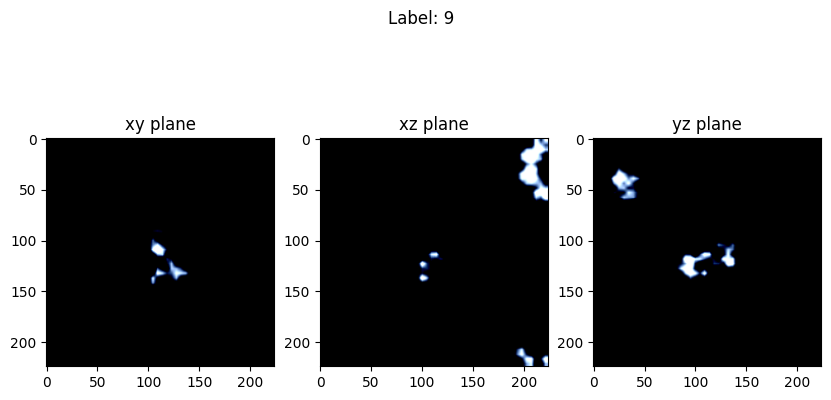

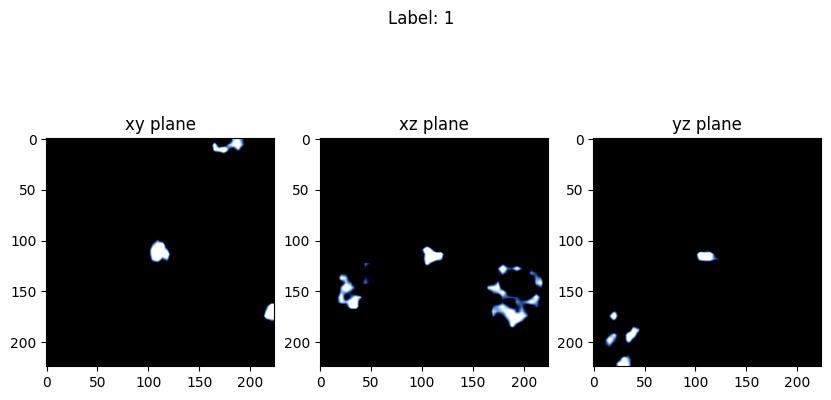

In [ ]:
# Visualizing a random sample

def visualize_random_sample(data_folder):
       random_file = random.choice(os.listdir(data_folder))
       file_path = os.path.join(data_folder, random_file)

       sample = torch.load(file_path)
       xy, xz, yz, label = sample[0][0], sample[0][1], sample[0][2], sample[1]

       xy = xy.permute(1, 2, 0).numpy()
       xz = xz.permute(1, 2, 0).numpy()
       yz = yz.permute(1, 2, 0).numpy()

       fig, axes = plt.subplots(1, 3, figsize=(10, 5))

       axes[0].imshow(xy)
       axes[0].set_title('xy plane')
       axes[1].imshow(xz)
       axes[1].set_title('xz plane')
       axes[2].imshow(yz)
       axes[2].set_title('yz plane')

       plt.suptitle(f'Label: {label}')

       plt.show()

visualize_random_sample(data_folder)
visualize_random_sample(data_folder)


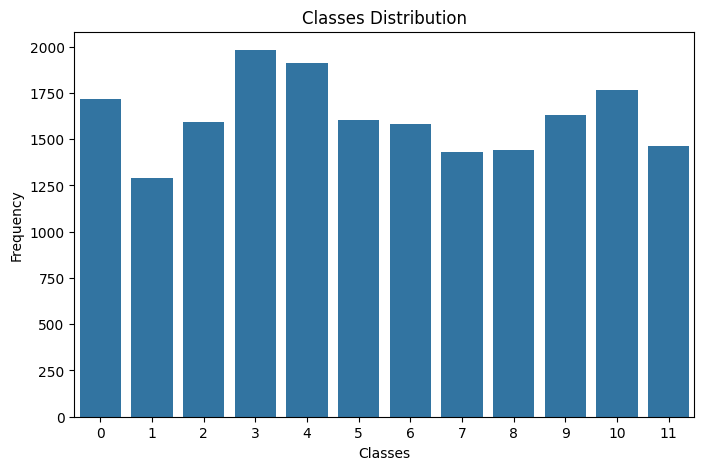

In [ ]:
# checking if there is a class imbalance

labels = []

for file_name in os.listdir(data_folder):
  sample = os.path.join(data_folder, file_name)
  if file_name.endswith('.pt'):
    sample = torch.load(sample)
    labels.append(sample[1])

labels_counts = Counter(labels)


plt.figure(figsize= (8, 5))
sns.barplot(x= list(labels_counts.keys()), y= list(labels_counts.values()))
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.title('Classes Distribution')
plt.show()

In [ ]:
labels_counts

Counter({2: 1592,
         10: 1768,
         4: 1911,
         6: 1580,
         7: 1432,
         9: 1629,
         0: 1719,
         11: 1463,
         1: 1290,
         5: 1605,
         8: 1440,
         3: 1982})

### Defining Penalization Weights to Handle Class Imbalance

In [ ]:
num_classes = max(labels_counts.keys()) + 1
class_counts = torch.zeros(num_classes, dtype=torch.float32)

for cls, count in labels_counts.items():
    class_counts[cls] = count

weights = 1.0 / class_counts

weights = weights / weights.sum()

penalize_weights = weights.to(dtype=torch.float32)
print("Penalization Weights:", penalize_weights)

Penalization Weights: tensor([0.0773, 0.1030, 0.0835, 0.0671, 0.0695, 0.0828, 0.0841, 0.0928, 0.0923,
        0.0816, 0.0752, 0.0908])


## ConvNext v1 and v2 Models Creation (From Hugging Face)

In [ ]:
from transformers import ConvNextForImageClassification, ConvNextConfig

def create_model(model_type='v1', num_labels=12):
    label2id = {str(i): i for i in range(num_labels)}
    id2label = {i: str(i) for i in range(num_labels)}

    if model_type == 'v1':
        config = ConvNextConfig.from_pretrained("facebook/convnext-tiny-224")
        config.num_labels = num_labels
        config.label2id = label2id
        config.id2label = id2label

        model = ConvNextForImageClassification.from_pretrained(
            "facebook/convnext-tiny-224",
            config=config,
            ignore_mismatched_sizes=True
        )
        return model

    elif model_type == 'v2':
        from transformers import ConvNextV2ForImageClassification, ConvNextV2Config
        config = ConvNextV2Config.from_pretrained("facebook/convnextv2-tiny-1k-224")
        config.num_labels = num_labels
        config.label2id = label2id
        config.id2label = id2label

        model = ConvNextV2ForImageClassification.from_pretrained(
            "facebook/convnextv2-tiny-1k-224",
            config=config,
            ignore_mismatched_sizes=True
        )
        return model

    else:
        raise ValueError("model_type must be 'v1' or 'v2'")


## Training and Validation Pipeline

### Defining Some Helper Functions for Gradually layer's unfreezing for the ConvNext v1 & v2 pretrained models

In [ ]:
def freeze_all(model):
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_classifier(model):
    for name, param in model.named_parameters():
        if "classifier" in name:
            param.requires_grad = True

def unfreeze_stages(model, stage_ids):
  if hasattr(model, "convnext"):  # ConvNeXt V1
        backbone = model.convnext
  elif hasattr(model, "convnextv2"):  # ConvNeXt V2
        backbone = model.convnextv2
  else:
        raise ValueError("Unsupported model structure. Cannot find backbone module.")

  for idx in stage_ids:
        for param in backbone.encoder.stages[idx].parameters():
            param.requires_grad = True

def build_optimizer(model, lr_head=1e-4, lr_backbone=1e-5):
    if hasattr(model, "convnext"):  # ConvNeXt V1
        backbone = model.convnext
    elif hasattr(model, "convnextv2"):  # ConvNeXt V2
        backbone = model.convnextv2
    else:
        raise ValueError("Unsupported model structure. Cannot find backbone module.")

    return torch.optim.AdamW([
        {'params': model.classifier.parameters(), 'lr': lr_head},
        {'params': filter(lambda p: p.requires_grad, backbone.parameters()), 'lr': lr_backbone}
    ])



### Train and validate function

In [ ]:
def train_and_validate(model_type='v1', save_path='best_model.pth', epochs=10, resume=False):
    early_stop_patience = 3  # stop if no improvement for N epochs
    early_stop_counter = 0

    model = create_model(model_type).to(device)

    freeze_all(model)                # Freeze all layers first
    unfreeze_classifier(model)      # Unfreeze classifier to train only it initially

    optimizer = build_optimizer(model)
    scaler = torch.amp.GradScaler()

    best_val_acc = 0.0
    start_epoch = 0
    history = {
        "train_loss": [], "train_acc": [],
        "val_loss": [], "val_acc": []
    }

    # Resume training if checkpoint exists
    checkpoint_path = f"{save_path}_checkpoint.pt"

    if resume and os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        start_epoch = checkpoint['epoch']
        best_val_acc = checkpoint.get('best_val_acc', 0.0)
        print(f"Resumed from epoch {start_epoch}, best_val_acc={best_val_acc:.4f}")

        # Re-apply unfreezing logic
        if start_epoch >= 5:
            print("[INFO] Re-unfreezing stage 3 after resume...")
            unfreeze_stages(model, [3])


        # Try loading optimizer state
        try:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        except ValueError:
            print("[WARNING] Optimizer state could not be loaded due to parameter mismatch. Rebuilding optimizer...")
            optimizer = build_optimizer(model)



    for epoch in range(start_epoch, epochs):
        # Gradually unfreeze ConvNeXt encoder stages
        if epoch == 5:
            print("[INFO] Unfreezing encoder stage 3...")
            unfreeze_stages(model, [3])
            optimizer = build_optimizer(model)

        start = time.time()
        model.train()
        train_loss, correct, total = 0, 0, 0

        for batch_idx, (inputs, labels) in enumerate(tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}/{epochs}")):
            B, V, C, H, W = inputs.shape
            inputs = inputs.view(B * V, C, H, W).to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            with torch.amp.autocast(device_type='cuda'):
                outputs = model(pixel_values=inputs)
                logits = outputs.logits.view(B, V, -1).mean(1)
                loss = F.cross_entropy(logits, labels, weight=penalize_weights.to(device))

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        avg_train_loss = train_loss / len(train_loader)
        train_acc = correct / total
        history["train_loss"].append(avg_train_loss)
        history["train_acc"].append(train_acc)

        print(f"[{model_type}] Epoch {epoch+1} — Train Loss: {avg_train_loss:.4f}, Accuracy: {train_acc:.4f}")

        # --- Validation ---
        model.eval()
        val_loss, all_preds, all_labels = 0, [], []

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"[Val] Epoch {epoch+1}/{epochs}"):
                B, V, C, H, W = inputs.shape
                inputs = inputs.view(B * V, C, H, W).to(device)
                labels = labels.to(device)

                with torch.amp.autocast(device_type='cuda'):
                    outputs = model(pixel_values=inputs)
                    logits = outputs.logits.view(B, V, -1).mean(1)
                    loss = F.cross_entropy(logits, labels)

                val_loss += loss.item()
                preds = torch.argmax(logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_acc = accuracy_score(all_labels, all_preds)
        history["val_loss"].append(avg_val_loss)
        history["val_acc"].append(val_acc)

        print(f"[{model_type}] Epoch {epoch+1} — Val Loss: {avg_val_loss:.4f}, Accuracy: {val_acc:.4f}")
        print(f"Time: {time.time() - start:.2f} sec\n")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), save_path)
            print(f"Best model saved to: {save_path}")
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_acc': best_val_acc,
                'seed': 42
            }, checkpoint_path)

            early_stop_counter = 0  # reset counter if improved
        else:
            early_stop_counter += 1
            print(f"[INFO] Early stopping counter: {early_stop_counter}/{early_stop_patience}")

            if early_stop_counter >= early_stop_patience:
                print("[EARLY STOPPING] Validation performance has not improved.")
                break


    return history


### Loss and Accuracy Curves Ploting Helper Function




In [ ]:
def loss_curve_plot(metrics):
  epochs = range(1, len(metrics['train_loss']) + 1)

  plt.figure(figsize=(8, 5))
  plt.plot(epochs, metrics['train_loss'], label='Train Loss')
  plt.plot(epochs, metrics['val_loss'], label='Val Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Loss Curve')
  plt.legend()
  plt.grid(True)
  plt.show()


def acc_curve_plot(metrics):
  epochs = range(1, len(metrics['train_acc'])+1)

  plt.figure(figsize=(8, 5))
  plt.plot(epochs, [a * 100 for a in metrics['train_acc']], label='Train Accuracy')
  plt.plot(epochs, [a * 100 for a in metrics['val_acc']], label='Val Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy (%)')
  plt.title('Accuracy Curve')
  plt.legend()
  plt.grid(True)
  plt.show()


## Training ConvNext V1 and Evaluate it on the Validation set

In [ ]:
# Train ConvNeXt V1 (Hugging Face version)
v1_metrics = train_and_validate(
    model_type='v1',
    save_path='/content/drive/MyDrive/SHREC2020/saved_models/best_convnextv1_hf.pth',
    epochs= 20,
    resume= False
)

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([12, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([12]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[Train] Epoch 1/20: 100%|██████████| 485/485 [02:58<00:00,  2.72it/s]


[v1] Epoch 1 — Train Loss: 2.2112, Accuracy: 0.4027


[Val] Epoch 1/20: 100%|██████████| 122/122 [00:45<00:00,  2.69it/s]


[v1] Epoch 1 — Val Loss: 1.9858, Accuracy: 0.5143
Time: 223.37 sec

Best model saved to: /content/drive/MyDrive/SHREC2020/saved_models/best_convnextv1_hf.pth


[Train] Epoch 2/20: 100%|██████████| 485/485 [03:08<00:00,  2.57it/s]


[v1] Epoch 2 — Train Loss: 1.8369, Accuracy: 0.5892


[Val] Epoch 2/20: 100%|██████████| 122/122 [00:51<00:00,  2.39it/s]


[v1] Epoch 2 — Val Loss: 1.7198, Accuracy: 0.5952
Time: 239.88 sec

Best model saved to: /content/drive/MyDrive/SHREC2020/saved_models/best_convnextv1_hf.pth


[Train] Epoch 3/20: 100%|██████████| 485/485 [03:18<00:00,  2.44it/s]


[v1] Epoch 3 — Train Loss: 1.6273, Accuracy: 0.6370


[Val] Epoch 3/20: 100%|██████████| 122/122 [00:49<00:00,  2.46it/s]


[v1] Epoch 3 — Val Loss: 1.5598, Accuracy: 0.6346
Time: 248.01 sec

Best model saved to: /content/drive/MyDrive/SHREC2020/saved_models/best_convnextv1_hf.pth


[Train] Epoch 4/20: 100%|██████████| 485/485 [03:13<00:00,  2.50it/s]


[v1] Epoch 4 — Train Loss: 1.4899, Accuracy: 0.6630


[Val] Epoch 4/20: 100%|██████████| 122/122 [00:48<00:00,  2.52it/s]


[v1] Epoch 4 — Val Loss: 1.4427, Accuracy: 0.6500
Time: 242.21 sec

Best model saved to: /content/drive/MyDrive/SHREC2020/saved_models/best_convnextv1_hf.pth


[Train] Epoch 5/20: 100%|██████████| 485/485 [03:11<00:00,  2.54it/s]


[v1] Epoch 5 — Train Loss: 1.3881, Accuracy: 0.6819


[Val] Epoch 5/20: 100%|██████████| 122/122 [00:48<00:00,  2.54it/s]


[v1] Epoch 5 — Val Loss: 1.3550, Accuracy: 0.6696
Time: 239.17 sec

Best model saved to: /content/drive/MyDrive/SHREC2020/saved_models/best_convnextv1_hf.pth
[INFO] Unfreezing encoder stage 3...


[Train] Epoch 6/20: 100%|██████████| 485/485 [03:16<00:00,  2.47it/s]


[v1] Epoch 6 — Train Loss: 0.7644, Accuracy: 0.8058


[Val] Epoch 6/20: 100%|██████████| 122/122 [00:51<00:00,  2.36it/s]


[v1] Epoch 6 — Val Loss: 0.4746, Accuracy: 0.8728
Time: 247.94 sec

Best model saved to: /content/drive/MyDrive/SHREC2020/saved_models/best_convnextv1_hf.pth


[Train] Epoch 7/20: 100%|██████████| 485/485 [03:27<00:00,  2.34it/s]


[v1] Epoch 7 — Train Loss: 0.3317, Accuracy: 0.9193


[Val] Epoch 7/20: 100%|██████████| 122/122 [00:50<00:00,  2.43it/s]


[v1] Epoch 7 — Val Loss: 0.2523, Accuracy: 0.9261
Time: 257.36 sec

Best model saved to: /content/drive/MyDrive/SHREC2020/saved_models/best_convnextv1_hf.pth


[Train] Epoch 8/20: 100%|██████████| 485/485 [03:17<00:00,  2.46it/s]


[v1] Epoch 8 — Train Loss: 0.1887, Accuracy: 0.9572


[Val] Epoch 8/20: 100%|██████████| 122/122 [00:51<00:00,  2.38it/s]


[v1] Epoch 8 — Val Loss: 0.1638, Accuracy: 0.9531
Time: 248.38 sec

Best model saved to: /content/drive/MyDrive/SHREC2020/saved_models/best_convnextv1_hf.pth


[Train] Epoch 9/20: 100%|██████████| 485/485 [03:30<00:00,  2.31it/s]


[v1] Epoch 9 — Train Loss: 0.1232, Accuracy: 0.9728


[Val] Epoch 9/20: 100%|██████████| 122/122 [00:56<00:00,  2.15it/s]


[v1] Epoch 9 — Val Loss: 0.1248, Accuracy: 0.9588
Time: 267.15 sec

Best model saved to: /content/drive/MyDrive/SHREC2020/saved_models/best_convnextv1_hf.pth


[Train] Epoch 10/20: 100%|██████████| 485/485 [03:48<00:00,  2.12it/s]


[v1] Epoch 10 — Train Loss: 0.0859, Accuracy: 0.9820


[Val] Epoch 10/20: 100%|██████████| 122/122 [00:57<00:00,  2.11it/s]


[v1] Epoch 10 — Val Loss: 0.0873, Accuracy: 0.9727
Time: 286.56 sec

Best model saved to: /content/drive/MyDrive/SHREC2020/saved_models/best_convnextv1_hf.pth


[Train] Epoch 11/20: 100%|██████████| 485/485 [03:45<00:00,  2.15it/s]


[v1] Epoch 11 — Train Loss: 0.0630, Accuracy: 0.9876


[Val] Epoch 11/20: 100%|██████████| 122/122 [00:55<00:00,  2.19it/s]


[v1] Epoch 11 — Val Loss: 0.0681, Accuracy: 0.9804
Time: 281.70 sec

Best model saved to: /content/drive/MyDrive/SHREC2020/saved_models/best_convnextv1_hf.pth


[Train] Epoch 12/20: 100%|██████████| 485/485 [03:40<00:00,  2.20it/s]


[v1] Epoch 12 — Train Loss: 0.0474, Accuracy: 0.9908


[Val] Epoch 12/20: 100%|██████████| 122/122 [00:57<00:00,  2.11it/s]


[v1] Epoch 12 — Val Loss: 0.0605, Accuracy: 0.9804
Time: 278.57 sec

[INFO] Early stopping counter: 1/3


[Train] Epoch 13/20: 100%|██████████| 485/485 [03:48<00:00,  2.13it/s]


[v1] Epoch 13 — Train Loss: 0.0352, Accuracy: 0.9939


[Val] Epoch 13/20: 100%|██████████| 122/122 [00:57<00:00,  2.12it/s]


[v1] Epoch 13 — Val Loss: 0.0479, Accuracy: 0.9851
Time: 285.61 sec

Best model saved to: /content/drive/MyDrive/SHREC2020/saved_models/best_convnextv1_hf.pth


[Train] Epoch 14/20: 100%|██████████| 485/485 [03:45<00:00,  2.15it/s]


[v1] Epoch 14 — Train Loss: 0.0262, Accuracy: 0.9959


[Val] Epoch 14/20: 100%|██████████| 122/122 [00:56<00:00,  2.16it/s]


[v1] Epoch 14 — Val Loss: 0.0466, Accuracy: 0.9866
Time: 282.38 sec

Best model saved to: /content/drive/MyDrive/SHREC2020/saved_models/best_convnextv1_hf.pth


[Train] Epoch 15/20: 100%|██████████| 485/485 [03:44<00:00,  2.16it/s]


[v1] Epoch 15 — Train Loss: 0.0209, Accuracy: 0.9966


[Val] Epoch 15/20: 100%|██████████| 122/122 [00:58<00:00,  2.10it/s]


[v1] Epoch 15 — Val Loss: 0.0379, Accuracy: 0.9889
Time: 282.78 sec

Best model saved to: /content/drive/MyDrive/SHREC2020/saved_models/best_convnextv1_hf.pth


[Train] Epoch 16/20: 100%|██████████| 485/485 [03:49<00:00,  2.11it/s]


[v1] Epoch 16 — Train Loss: 0.0150, Accuracy: 0.9985


[Val] Epoch 16/20: 100%|██████████| 122/122 [00:58<00:00,  2.08it/s]


[v1] Epoch 16 — Val Loss: 0.0345, Accuracy: 0.9884
Time: 288.50 sec

[INFO] Early stopping counter: 1/3


[Train] Epoch 17/20: 100%|██████████| 485/485 [03:49<00:00,  2.11it/s]


[v1] Epoch 17 — Train Loss: 0.0112, Accuracy: 0.9993


[Val] Epoch 17/20: 100%|██████████| 122/122 [00:56<00:00,  2.16it/s]


[v1] Epoch 17 — Val Loss: 0.0368, Accuracy: 0.9882
Time: 286.32 sec

[INFO] Early stopping counter: 2/3


[Train] Epoch 18/20: 100%|██████████| 485/485 [03:44<00:00,  2.16it/s]


[v1] Epoch 18 — Train Loss: 0.0081, Accuracy: 0.9998


[Val] Epoch 18/20: 100%|██████████| 122/122 [00:58<00:00,  2.10it/s]


[v1] Epoch 18 — Val Loss: 0.0298, Accuracy: 0.9892
Time: 282.56 sec

Best model saved to: /content/drive/MyDrive/SHREC2020/saved_models/best_convnextv1_hf.pth


[Train] Epoch 19/20: 100%|██████████| 485/485 [03:47<00:00,  2.13it/s]


[v1] Epoch 19 — Train Loss: 0.0063, Accuracy: 0.9999


[Val] Epoch 19/20: 100%|██████████| 122/122 [00:59<00:00,  2.05it/s]


[v1] Epoch 19 — Val Loss: 0.0291, Accuracy: 0.9897
Time: 286.81 sec

Best model saved to: /content/drive/MyDrive/SHREC2020/saved_models/best_convnextv1_hf.pth


[Train] Epoch 20/20: 100%|██████████| 485/485 [03:50<00:00,  2.11it/s]


[v1] Epoch 20 — Train Loss: 0.0045, Accuracy: 1.0000


[Val] Epoch 20/20: 100%|██████████| 122/122 [00:56<00:00,  2.15it/s]


[v1] Epoch 20 — Val Loss: 0.0275, Accuracy: 0.9902
Time: 286.93 sec

Best model saved to: /content/drive/MyDrive/SHREC2020/saved_models/best_convnextv1_hf.pth


### Visualize the loss and accuracy curves to make sure that ConvNext v1 is not overfiting

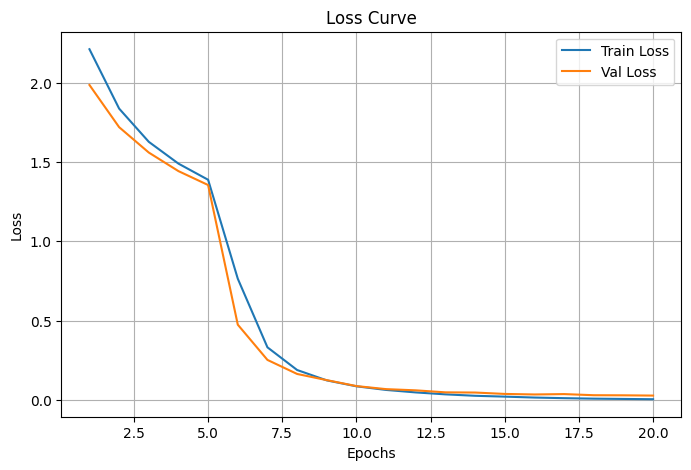

<Figure size 640x480 with 0 Axes>

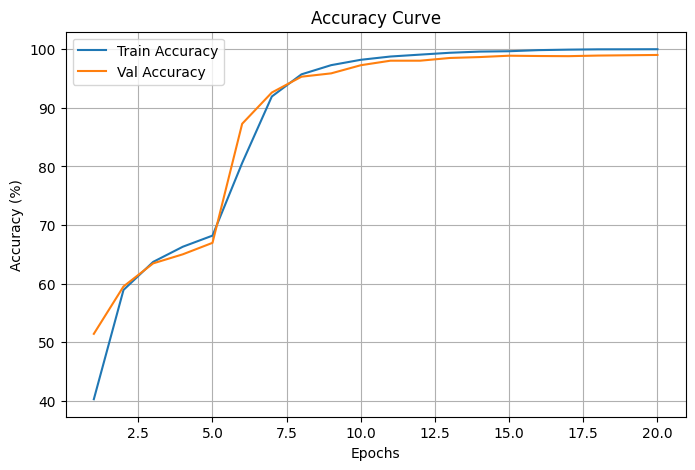

<Figure size 640x480 with 0 Axes>

In [ ]:
loss_curve_plot(v1_metrics)
plt.savefig('v1_Training_Validation_Loss_Curve.png')
acc_curve_plot(v1_metrics)
plt.savefig('v1_Training_Validation_Accuracy_Curve.png')


## Training ConvNext V2 and Evaluate it on the Validation set

In [ ]:
# Train ConvNeXt V2 (Hugging Face version)
v2_metrics = train_and_validate(
    model_type='v2',
    save_path='/content/drive/MyDrive/SHREC2020/saved_models/best_convnextv2_hf.pth',
    epochs= 20,
    resume= False
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

Some weights of ConvNextV2ForImageClassification were not initialized from the model checkpoint at facebook/convnextv2-tiny-1k-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([12]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([12, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[Train] Epoch 1/20: 100%|██████████| 485/485 [03:33<00:00,  2.27it/s]


[v2] Epoch 1 — Train Loss: 2.1408, Accuracy: 0.4120


[Val] Epoch 1/20: 100%|██████████| 122/122 [00:54<00:00,  2.25it/s]


[v2] Epoch 1 — Val Loss: 1.8915, Accuracy: 0.4811
Time: 267.68 sec

Best model saved to: /content/drive/MyDrive/SHREC2020/saved_models/best_convnextv2_hf.pth


[Train] Epoch 2/20: 100%|██████████| 485/485 [03:44<00:00,  2.16it/s]


[v2] Epoch 2 — Train Loss: 1.7295, Accuracy: 0.5742


[Val] Epoch 2/20: 100%|██████████| 122/122 [00:59<00:00,  2.05it/s]


[v2] Epoch 2 — Val Loss: 1.6161, Accuracy: 0.5856
Time: 284.14 sec

Best model saved to: /content/drive/MyDrive/SHREC2020/saved_models/best_convnextv2_hf.pth


[Train] Epoch 3/20: 100%|██████████| 485/485 [04:01<00:00,  2.01it/s]


[v2] Epoch 3 — Train Loss: 1.5146, Accuracy: 0.6291


[Val] Epoch 3/20: 100%|██████████| 122/122 [01:03<00:00,  1.92it/s]


[v2] Epoch 3 — Val Loss: 1.4531, Accuracy: 0.6070
Time: 305.06 sec

Best model saved to: /content/drive/MyDrive/SHREC2020/saved_models/best_convnextv2_hf.pth


[Train] Epoch 4/20: 100%|██████████| 485/485 [04:00<00:00,  2.02it/s]


[v2] Epoch 4 — Train Loss: 1.3754, Accuracy: 0.6566


[Val] Epoch 4/20: 100%|██████████| 122/122 [01:00<00:00,  2.01it/s]


[v2] Epoch 4 — Val Loss: 1.3381, Accuracy: 0.6402
Time: 301.43 sec

Best model saved to: /content/drive/MyDrive/SHREC2020/saved_models/best_convnextv2_hf.pth


[Train] Epoch 5/20: 100%|██████████| 485/485 [04:00<00:00,  2.01it/s]


[v2] Epoch 5 — Train Loss: 1.2747, Accuracy: 0.6758


[Val] Epoch 5/20: 100%|██████████| 122/122 [01:03<00:00,  1.92it/s]


[v2] Epoch 5 — Val Loss: 1.2518, Accuracy: 0.6608
Time: 304.51 sec

Best model saved to: /content/drive/MyDrive/SHREC2020/saved_models/best_convnextv2_hf.pth
[INFO] Unfreezing encoder stage 3...


[Train] Epoch 6/20: 100%|██████████| 485/485 [04:19<00:00,  1.87it/s]


[v2] Epoch 6 — Train Loss: 0.6521, Accuracy: 0.8117


[Val] Epoch 6/20: 100%|██████████| 122/122 [01:02<00:00,  1.94it/s]


[v2] Epoch 6 — Val Loss: 0.3847, Accuracy: 0.8720
Time: 321.96 sec

Best model saved to: /content/drive/MyDrive/SHREC2020/saved_models/best_convnextv2_hf.pth


[Train] Epoch 7/20: 100%|██████████| 485/485 [04:10<00:00,  1.93it/s]


[v2] Epoch 7 — Train Loss: 0.2519, Accuracy: 0.9325


[Val] Epoch 7/20: 100%|██████████| 122/122 [01:01<00:00,  1.99it/s]


[v2] Epoch 7 — Val Loss: 0.1823, Accuracy: 0.9464
Time: 312.18 sec

Best model saved to: /content/drive/MyDrive/SHREC2020/saved_models/best_convnextv2_hf.pth


[Train] Epoch 8/20: 100%|██████████| 485/485 [04:11<00:00,  1.93it/s]


[v2] Epoch 8 — Train Loss: 0.1363, Accuracy: 0.9676


[Val] Epoch 8/20: 100%|██████████| 122/122 [01:04<00:00,  1.89it/s]


[v2] Epoch 8 — Val Loss: 0.1169, Accuracy: 0.9686
Time: 315.82 sec

Best model saved to: /content/drive/MyDrive/SHREC2020/saved_models/best_convnextv2_hf.pth


[Train] Epoch 9/20: 100%|██████████| 485/485 [04:20<00:00,  1.86it/s]


[v2] Epoch 9 — Train Loss: 0.0876, Accuracy: 0.9793


[Val] Epoch 9/20: 100%|██████████| 122/122 [01:03<00:00,  1.92it/s]


[v2] Epoch 9 — Val Loss: 0.0898, Accuracy: 0.9766
Time: 323.81 sec

Best model saved to: /content/drive/MyDrive/SHREC2020/saved_models/best_convnextv2_hf.pth


[Train] Epoch 10/20: 100%|██████████| 485/485 [04:16<00:00,  1.89it/s]


[v2] Epoch 10 — Train Loss: 0.0620, Accuracy: 0.9860


[Val] Epoch 10/20: 100%|██████████| 122/122 [01:07<00:00,  1.80it/s]


[v2] Epoch 10 — Val Loss: 0.0646, Accuracy: 0.9848
Time: 324.09 sec

Best model saved to: /content/drive/MyDrive/SHREC2020/saved_models/best_convnextv2_hf.pth


[Train] Epoch 11/20: 100%|██████████| 485/485 [04:33<00:00,  1.77it/s]


[v2] Epoch 11 — Train Loss: 0.0445, Accuracy: 0.9912


[Val] Epoch 11/20: 100%|██████████| 122/122 [01:10<00:00,  1.74it/s]


[v2] Epoch 11 — Val Loss: 0.0532, Accuracy: 0.9874
Time: 344.02 sec

Best model saved to: /content/drive/MyDrive/SHREC2020/saved_models/best_convnextv2_hf.pth


[Train] Epoch 12/20: 100%|██████████| 485/485 [04:32<00:00,  1.78it/s]


[v2] Epoch 12 — Train Loss: 0.0326, Accuracy: 0.9941


[Val] Epoch 12/20: 100%|██████████| 122/122 [01:08<00:00,  1.77it/s]


[v2] Epoch 12 — Val Loss: 0.0470, Accuracy: 0.9864
Time: 341.52 sec

[INFO] Early stopping counter: 1/3


[Train] Epoch 13/20: 100%|██████████| 485/485 [04:31<00:00,  1.79it/s]


[v2] Epoch 13 — Train Loss: 0.0245, Accuracy: 0.9960


[Val] Epoch 13/20: 100%|██████████| 122/122 [01:07<00:00,  1.82it/s]


[v2] Epoch 13 — Val Loss: 0.0431, Accuracy: 0.9876
Time: 338.64 sec

Best model saved to: /content/drive/MyDrive/SHREC2020/saved_models/best_convnextv2_hf.pth


[Train] Epoch 14/20: 100%|██████████| 485/485 [04:31<00:00,  1.78it/s]


[v2] Epoch 14 — Train Loss: 0.0180, Accuracy: 0.9978


[Val] Epoch 14/20: 100%|██████████| 122/122 [01:10<00:00,  1.73it/s]


[v2] Epoch 14 — Val Loss: 0.0343, Accuracy: 0.9923
Time: 342.66 sec

Best model saved to: /content/drive/MyDrive/SHREC2020/saved_models/best_convnextv2_hf.pth


[Train] Epoch 15/20: 100%|██████████| 485/485 [04:29<00:00,  1.80it/s]


[v2] Epoch 15 — Train Loss: 0.0137, Accuracy: 0.9984


[Val] Epoch 15/20: 100%|██████████| 122/122 [01:09<00:00,  1.76it/s]


[v2] Epoch 15 — Val Loss: 0.0296, Accuracy: 0.9915
Time: 339.07 sec

[INFO] Early stopping counter: 1/3


[Train] Epoch 16/20: 100%|██████████| 485/485 [04:30<00:00,  1.80it/s]


[v2] Epoch 16 — Train Loss: 0.0098, Accuracy: 0.9994


[Val] Epoch 16/20: 100%|██████████| 122/122 [01:07<00:00,  1.80it/s]


[v2] Epoch 16 — Val Loss: 0.0282, Accuracy: 0.9923
Time: 337.96 sec

[INFO] Early stopping counter: 2/3


[Train] Epoch 17/20: 100%|██████████| 485/485 [04:33<00:00,  1.77it/s]


[v2] Epoch 17 — Train Loss: 0.0074, Accuracy: 0.9996


[Val] Epoch 17/20: 100%|██████████| 122/122 [01:10<00:00,  1.73it/s]

[v2] Epoch 17 — Val Loss: 0.0291, Accuracy: 0.9915
Time: 344.24 sec

[INFO] Early stopping counter: 3/3
[EARLY STOPPING] Validation performance has not improved.


### Visualize the loss and accuracy curves to make sure that ConvNext v1 is not overfiting

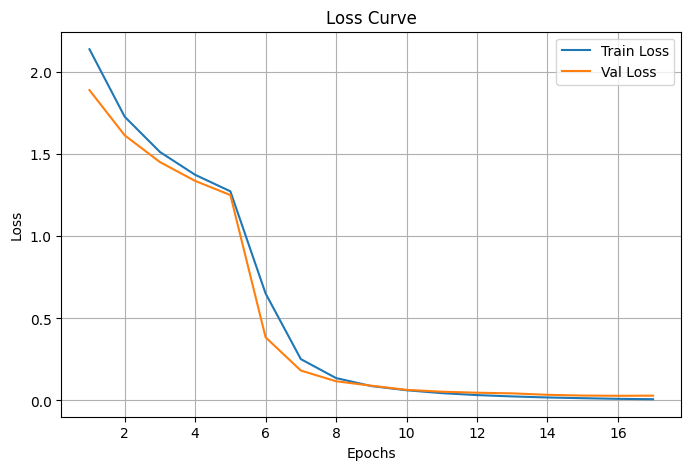

<Figure size 640x480 with 0 Axes>

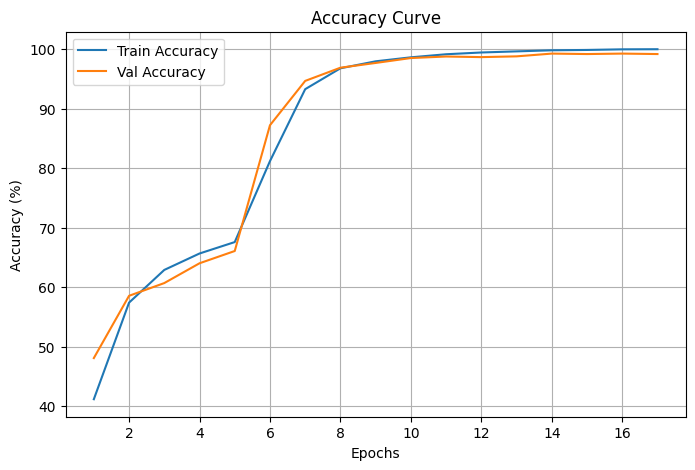

<Figure size 640x480 with 0 Axes>

In [ ]:
loss_curve_plot(v2_metrics)
plt.savefig('v2_Training_Validation_Loss_Curve.png')
acc_curve_plot(v2_metrics)
plt.savefig('v2_Training_Validation_Accuracy_Curve.png')

## Inference (Test) Pipeline on Tomogram 9

In [ ]:
def run_inference(model_type, ckpt_path, output_csv_name):
    print(f"\nRunning inference with {model_type}...")

    # Create and load the model
    model = create_model(model_type)
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    model.to(device)
    model.eval()

    all_preds, all_labels, coordinates = [], [], []
    patch_size = 48
    half = patch_size // 2
    shape_z, shape_y, shape_x = volume.shape

    start_time = time.time()

    for i, (pdb_id, x, y, z, *_) in enumerate(tqdm(particles, desc="Running inference")):
        # Convert coordinates to integers
        x, y, z = int(float(x)), int(float(y)), int(float(z))

        # Check that the patch is fully within the volume
        if (x - half < 0 or y - half < 0 or z - half < 0 or
            x + half >= shape_x or y + half >= shape_y or z + half >= shape_z):
            continue

        # Extract a patch (cube) centered at the particle location
        patch = volume[z-half:z+half, y-half:y+half, x-half:x+half]

        # Extract the central slices for each view:
        xy_img = Image.fromarray(normalize_to_uint8(patch[half, :, :])).convert('RGB')
        xz_img = Image.fromarray(normalize_to_uint8(patch[:, half, :])).convert('RGB')
        yz_img = Image.fromarray(normalize_to_uint8(patch[:, :, half])).convert('RGB')

        # Transform the images to tensors
        xy_tensor = transform(xy_img)
        xz_tensor = transform(xz_img)
        yz_tensor = transform(yz_img)

        # Create a triplet tensor (3 views); shape: [3, 3, 224, 224]
        triplet = torch.stack([xy_tensor, xz_tensor, yz_tensor])
        # Add a batch dimension: shape becomes [1, 3, 3, 224, 224]
        triplet = triplet.unsqueeze(0).to(device)

        # Get dimensions and reshape to merge batch and view dimensions
        B, V, C, H, W = triplet.shape  # Expected B=1, V=3, C=3, H=224, W=224
        triplet = triplet.view(B * V, C, H, W)

        # Run inference with mixed precision
        with torch.no_grad(), torch.amp.autocast(device_type='cuda'):
            outputs = model(pixel_values=triplet)
            # Reshape logits to [B, V, num_labels] and average over the views
            logits = outputs.logits.view(B, V, -1).mean(1)
            pred = torch.argmax(logits, dim=1).item()

        # Collect predictions, ground truth, and coordinates
        all_preds.append(pred)
        all_labels.append(pdb_to_idx[pdb_id])
        coordinates.append((x, y, z))

    elapsed = time.time() - start_time
    print(f"Inference time for {model_type}: {elapsed:.2f} seconds")

    # Save predictions to a CSV file
    csv_path = os.path.join('/content/', output_csv_name)
    with open(csv_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['pred_class', 'true_class', 'x', 'y', 'z'])
        for pred, true, (x, y, z) in zip(all_preds, all_labels, coordinates):
            writer.writerow([idx_to_pdb[pred], idx_to_pdb[true], x, y, z])
    files.download(csv_path)
    # Calculate metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    print(f"\nEvaluation for {model_type}:")
    print(f"Accuracy  : {acc:.4f}")
    print(f"Precision : {prec:.4f}")
    print(f"Recall    : {rec:.4f}")
    print(f"F1 Score  : {f1:.4f}")
    print("\nDetailed Classification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=[idx_to_pdb[i] for i in range(12)], zero_division=0))


### Helper function for inference performance comparitive visualization


In [ ]:
def compare_models(csv1, csv2, model1_name="Model 1", model2_name="Model 2", save_path=None):
    """
    Compares two classification models using their prediction CSVs.

    Args:
        csv1 (str): Path to Model 1 predictions CSV.
        csv2 (str): Path to Model 2 predictions CSV.
        model1_name (str): Name label for Model 1.
        model2_name (str): Name label for Model 2.
        save_path (str): Optional folder to save comparison plots.
    """
    # Load both predictions
    df1 = pd.read_csv(csv1)
    df2 = pd.read_csv(csv2)

    # Extract data
    y_true1, y_pred1 = df1['true_class'], df1['pred_class']
    y_true2, y_pred2 = df2['true_class'], df2['pred_class']
    labels = sorted(df1['true_class'].unique())

    # --- Metrics summary ---
    report1 = classification_report(y_true1, y_pred1, labels=labels, output_dict=True)
    report2 = classification_report(y_true2, y_pred2, labels=labels, output_dict=True)

    print(f"\n📋 {model1_name} Macro Metrics:")
    print(f"Accuracy: {report1['accuracy']:.4f}, Precision: {report1['macro avg']['precision']:.4f}, "
          f"Recall: {report1['macro avg']['recall']:.4f}, F1: {report1['macro avg']['f1-score']:.4f}")

    print(f"\n📋 {model2_name} Macro Metrics:")
    print(f"Accuracy: {report2['accuracy']:.4f}, Precision: {report2['macro avg']['precision']:.4f}, "
          f"Recall: {report2['macro avg']['recall']:.4f}, F1: {report2['macro avg']['f1-score']:.4f}")

    # --- 1. F1-score per class comparison ---
    f1_1 = [report1[str(label)]['f1-score'] for label in labels]
    f1_2 = [report2[str(label)]['f1-score'] for label in labels]

    x = np.arange(len(labels))
    width = 0.35

    plt.figure(figsize=(12, 5))
    plt.bar(x - width/2, f1_1, width, label=model1_name)
    plt.bar(x + width/2, f1_2, width, label=model2_name)
    plt.xticks(x, labels, rotation=45)
    plt.ylabel('F1 Score')
    plt.title('Class-wise F1 Score Comparison')
    plt.legend()
    plt.tight_layout()
    if save_path:
        plt.savefig(os.path.join(save_path, "f1_score_comparison.png"))
    plt.show()

    # --- 2. Confusion Matrices ---
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    cm1 = confusion_matrix(y_true1, y_pred1, labels=labels)
    cm2 = confusion_matrix(y_true2, y_pred2, labels=labels)

    sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axs[0])
    axs[0].set_title(f'{model1_name} Confusion Matrix')
    axs[0].set_xlabel('Predicted')
    axs[0].set_ylabel('True')

    sns.heatmap(cm2, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels, ax=axs[1])
    axs[1].set_title(f'{model2_name} Confusion Matrix')
    axs[1].set_xlabel('Predicted')
    axs[1].set_ylabel('True')

    plt.tight_layout()
    if save_path:
        plt.savefig(os.path.join(save_path, "confusion_matrices_comparison.png"))
    plt.show()


## Performance Evaluation on the Test set (Tomogram 9) for both of the ConvNext V1 and V2 Models

---

### Run inference for ConvNext v1

In [ ]:
run_inference(
    model_type='v1',
    ckpt_path='/content/drive/MyDrive/SHREC2020/saved_models/best_convnextv1_hf.pth',
    output_csv_name='predictions_model9_v1.csv'
)


Running inference with v1...


Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([12, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([12]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Running inference: 100%|██████████| 2782/2782 [00:36<00:00, 75.99it/s]

Inference time for v1: 36.61 seconds


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Evaluation for v1:
Accuracy  : 0.9894
Precision : 0.9887
Recall    : 0.9887
F1 Score  : 0.9887

Detailed Classification Report:

              precision    recall  f1-score   support

        3cf3       1.00      1.00      1.00       202
        1s3x       0.96      0.97      0.97       168
        1u6g       0.98      0.99      0.99       178
        4cr2       1.00      1.00      1.00       231
        1qvr       1.00      1.00      1.00       213
        3h84       1.00      0.99      1.00       194
        2cg9       0.98      0.99      0.99       176
        3qm1       0.96      0.97      0.97       177
        3gl1       1.00      0.98      0.99       178
        3d2f       0.98      0.98      0.98       168
        4d8q       1.00      1.00      1.00       210
        1bxn       1.00      1.00      1.00       177

    accuracy                           0.99      2272
   macro avg       0.99      0.99      0.99      2272
weighted avg       0.99      0.99      0.99      2272



### Run inference for ConvNext v2

In [ ]:
run_inference(
    model_type='v2',
    ckpt_path='/content/drive/MyDrive/SHREC2020/saved_models/best_convnextv2_hf.pth',
    output_csv_name='predictions_model9_v2.csv'
)


Running inference with v2...


Some weights of ConvNextV2ForImageClassification were not initialized from the model checkpoint at facebook/convnextv2-tiny-1k-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([12]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([12, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Running inference: 100%|██████████| 2782/2782 [00:45<00:00, 61.46it/s]

Inference time for v2: 45.26 seconds


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Evaluation for v2:
Accuracy  : 0.9868
Precision : 0.9868
Recall    : 0.9856
F1 Score  : 0.9857

Detailed Classification Report:

              precision    recall  f1-score   support

        3cf3       1.00      1.00      1.00       202
        1s3x       0.99      0.89      0.94       168
        1u6g       0.97      0.99      0.98       178
        4cr2       1.00      1.00      1.00       231
        1qvr       0.99      1.00      1.00       213
        3h84       1.00      0.99      1.00       194
        2cg9       1.00      0.97      0.98       176
        3qm1       0.90      0.99      0.94       177
        3gl1       0.99      0.99      0.99       178
        3d2f       0.99      1.00      0.99       168
        4d8q       1.00      1.00      1.00       210
        1bxn       1.00      1.00      1.00       177

    accuracy                           0.99      2272
   macro avg       0.99      0.99      0.99      2272
weighted avg       0.99      0.99      0.99      2272



### Inference Performace Comparative Analysis


📋 ConvNeXt v1 Macro Metrics:
Accuracy: 0.9894, Precision: 0.9887, Recall: 0.9887, F1: 0.9887

📋 ConvNeXt v2 Macro Metrics:
Accuracy: 0.9868, Precision: 0.9868, Recall: 0.9856, F1: 0.9857


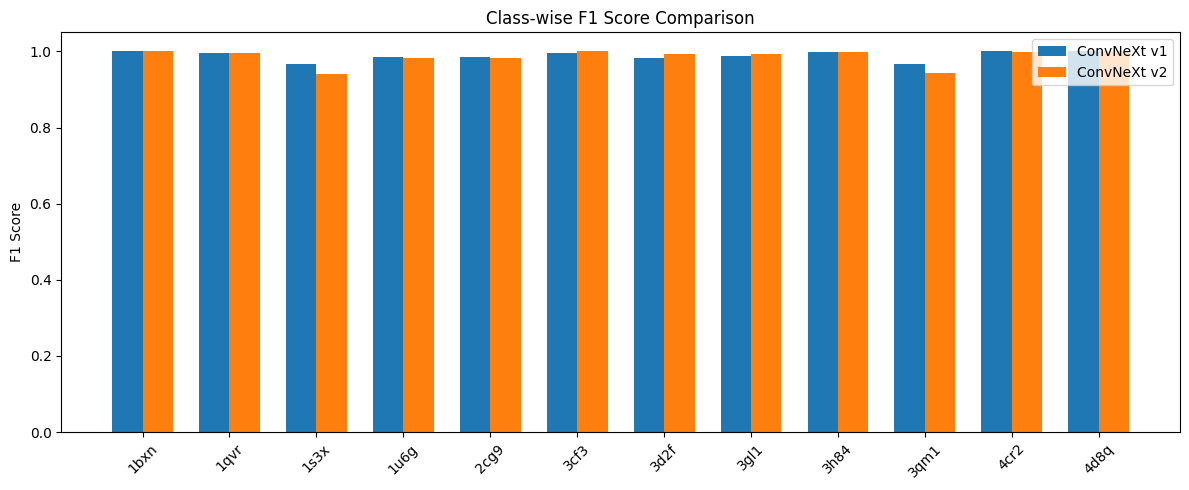

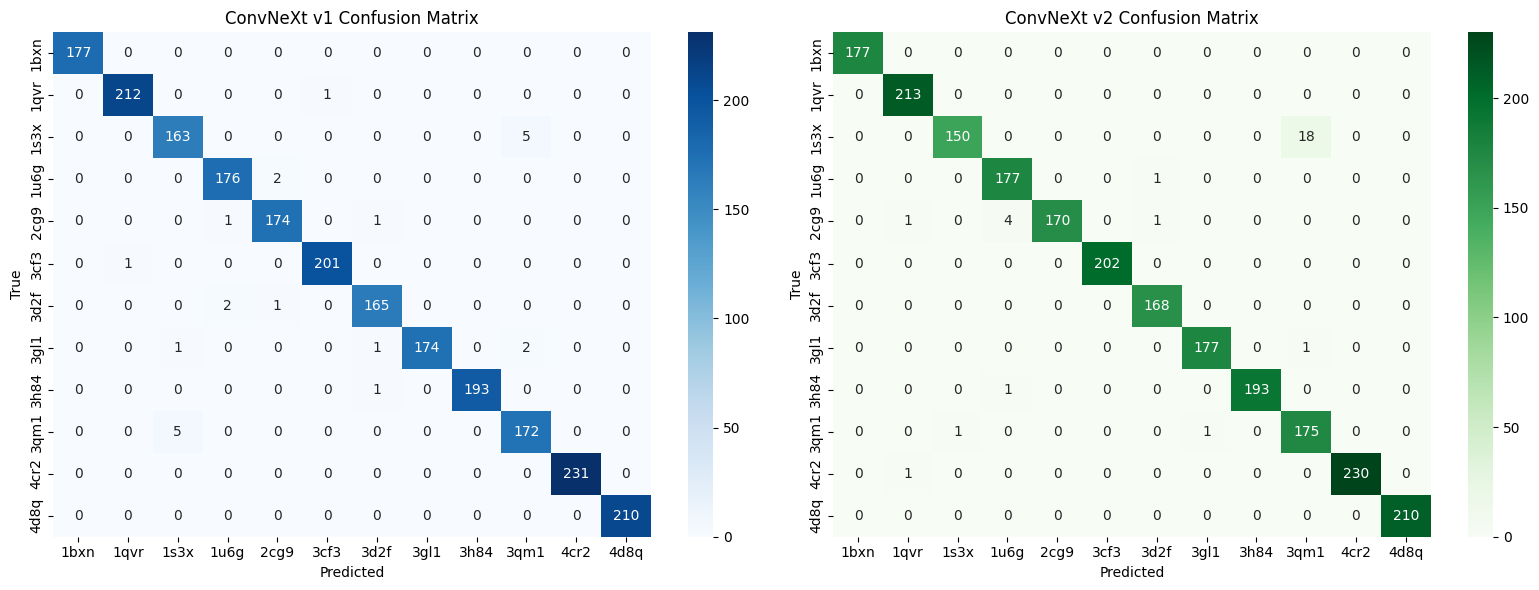

In [ ]:
compare_models('/content/predictions_model9_v1.csv', '/content/predictions_model9_v2.csv', 'ConvNeXt v1', 'ConvNeXt v2', '/content/')

### Exporting the Classification Result Tables

In [ ]:
# Load both predictions
df1 = pd.read_csv('/content/predictions_model9_v1.csv')
df2 = pd.read_csv('/content/predictions_model9_v2.csv')

# Extract data
y_true1, y_pred1 = df1['true_class'], df1['pred_class']
y_true2, y_pred2 = df2['true_class'], df2['pred_class']
labels = sorted(df1['true_class'].unique())

# Generate classification reports
report1 = classification_report(y_true1, y_pred1, labels=labels, output_dict=True)
report2 = classification_report(y_true2, y_pred2, labels=labels, output_dict=True)

# Convert to DataFrames
df_report1 = pd.DataFrame(report1).transpose()
df_report2 = pd.DataFrame(report2).transpose()

# Print the tables
print("Classification Report for Model 9 v1 (Table Format):")
print(df_report1)
print("\nClassification Report for Model 9 v2 (Table Format):")
print(df_report2)

# Save to Excel with openpyxl engine
output_path = '/content/classification_reports_model9.xlsx'
with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
    df_report1.to_excel(writer, sheet_name='Model9_v1_Report')
    df_report2.to_excel(writer, sheet_name='Model9_v2_Report')

print(f"\nReports saved to Excel at: {output_path}")


Classification Report for Model 9 v1 (Table Format):
              precision    recall  f1-score      support
1bxn           1.000000  1.000000  1.000000   177.000000
1qvr           0.995305  0.995305  0.995305   213.000000
1s3x           0.964497  0.970238  0.967359   168.000000
1u6g           0.983240  0.988764  0.985994   178.000000
2cg9           0.983051  0.988636  0.985836   176.000000
3cf3           0.995050  0.995050  0.995050   202.000000
3d2f           0.982143  0.982143  0.982143   168.000000
3gl1           1.000000  0.977528  0.988636   178.000000
3h84           1.000000  0.994845  0.997416   194.000000
3qm1           0.960894  0.971751  0.966292   177.000000
4cr2           1.000000  1.000000  1.000000   231.000000
4d8q           1.000000  1.000000  1.000000   210.000000
accuracy       0.989437  0.989437  0.989437     0.989437
macro avg      0.988682  0.988688  0.988669  2272.000000
weighted avg   0.989502  0.989437  0.989454  2272.000000

Classification Report for Model 9 